In [1]:
import os
# from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.utils import load_img
import numpy as np
import pandas as pd
from keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Display
from IPython.display import Image, display
import matplotlib.cm as cm

In [2]:
curr_path = os.getcwd()
random_seed =42

In [3]:
%%script echo skip
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

skip


In [4]:
path_in = '/kaggle/input/assn-5-load/Group_20'
path_model = '/kaggle/input/output-layer-vgg19'
print(os.listdir(path_model))
# os.listdir(path_in)

['output_layer_epoch_2_weights.csv', 'output_layer_epoch_2_bias.csv']


In [5]:
# os.chdir(curr_path)

In [6]:
%%script echo skip
drive.mount('/content/drive')
path = '/content/drive/My Drive/Assn_5/'
os.chdir(path)

skip


In [7]:
%%script echo skip
!unzip Group_20.zip 

skip


In [8]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [9]:
vgg19 = tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    classes=1000,
    classifier_activation="softmax"
)

574710816/574710816 [==============================] - 3s 0us/step


In [10]:
# print(vgg19.summary())

In [11]:
%%script echo skip
plot_model(vgg19, show_shapes=False, show_layer_activations=True, to_file='vgg19-(1).png')

skip


In [12]:
%%script echo skip
for i, hl in enumerate(vgg19.layers):
    print(i, " ", hl.name)

skip


In [13]:
%%script echo skip this shit
## create a new layer and add weights to it
vgg19_transfer = tf.keras.models.Sequential() #name=transfer_learning
for i in range(len(vgg19.layers) - 1):
    vgg19_transfer.add(vgg19.layers[i])

skip this shit


In [14]:
# freeze all the convolution layers in training
for hl in vgg19.layers:
    hl.trainable = False

In [15]:
%%script echo skip
# add a new classification/output layer
vgg19_transfer.add(Dense(5, activation = 'softmax', kernel_initializer=glorot_normal(seed=42), name='output_layer'))

skip


In [16]:
%%script echo skip
vgg19_transfer.summary()

skip


### Transfer learning with ~sequential model~
- It simply won't work because we are passing a model as a layer to our model

In [17]:
inp = tf.keras.layers.Input(shape=(224, 224, 3))
base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=inp,
                                          input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [18]:
## plot_model(vgg19, show_shapes=False, show_layer_activations=True)
# base_model.summary()

### Save layer weight callback 

In [20]:
# Define the layers whose weights you want to save
layer_names = ['output_layer']

# Define the custom callback function to save the weights of specific layers
class SaveLayerWeightsCallback(ModelCheckpoint):
    def __init__(self, filepath, layers, **kwargs):
        self.layers = layers
        self.filepath = filepath
        super().__init__(filepath, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        for layer_name in self.layers:
            layer = self.model.get_layer(layer_name)
            weights = layer.get_weights()
            if not os.path.exists(self.filepath):
              os.mkdir(self.filepath)
            filename1 = f"{layer_name}_epoch_{epoch}_weights.csv"
            filename2 = f"{layer_name}_epoch_{epoch}_bias.csv"
            filepath1 = os.path.join(self.filepath, filename1)
            filepath2 = os.path.join(self.filepath, filename2)
            # layer.save_weights(filepath)
            pd.DataFrame(weights[0]).to_csv(filepath1, index=False)
            pd.DataFrame(np.array([weights[1]])).to_csv(filepath2, index=False)
            # pd.DataFrame(weights).to_csv(filepath) # this saves array as a string and which is problamatic



In [21]:
threshold_val = 0.0001
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3,
                                                  min_delta=threshold_val,
                                                  mode='min',
                                                  restore_best_weights=True, 
                                                  verbose=1)

In [22]:
%%script echo skip
# Create an instance of the custom callback
save_layer_weights = SaveLayerWeightsCallback(filepath='sequential-model-weights/', layers=layer_names)

skip


In [23]:
lr=1e-3
epsilon_val=1e-8
beta1=0.9
beta2=0.999

In [24]:
%%script echo skip
vgg19_transfer.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                       optimizer=keras.optimizers.Adam(learning_rate=lr,
                                                       epsilon=epsilon_val,
                                                       beta_1=beta1,
                                                       beta_2=beta2),
                        metrics=['accuracy'])

skip


In [25]:
%%script echo skip
plot_model(vgg19_transfer, show_shapes=False, show_layer_activations=True)

skip


In [26]:
# os.chdir(path_model)
print(path_model)
best_w = pd.read_csv(path_model + '/output_layer_epoch_2_weights.csv', dtype='float32').values
best_b = pd.read_csv(path_model + '/output_layer_epoch_2_bias.csv', dtype='float32').values[0]

/kaggle/input/output-layer-vgg19


In [27]:

Flatten = tf.keras.layers.Flatten(name="flatten")
fc1 = tf.keras.layers.Dense(4096, activation='relu', name='fc1')
fc2 = tf.keras.layers.Dense(4096, activation='relu', name = 'fc2')
prediction = tf.keras.layers.Dense(5, activation='softmax', name='output')

imsize = [224, 224, 3]
inp = layers.Input(shape=(imsize[0], imsize[1], imsize[2]))
base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=inp,
                                          input_shape=(imsize[0], imsize[1], imsize[2]))

block5_pool = base_model.get_layer('block5_pool')
x = Flatten(block5_pool.output)
x = fc1(x)
x = fc2(x)
x = prediction(x)

model = tf.keras.models.Model(inputs = inp, outputs = x)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                       optimizer=keras.optimizers.Adam(learning_rate=lr,
                                                       epsilon=epsilon_val,
                                                       beta_1=beta1,
                                                       beta_2=beta2),
                        metrics=['accuracy'])

model.get_layer('fc1').set_weights(vgg19.get_layer('fc1').get_weights())
model.get_layer('fc2').set_weights(vgg19.get_layer('fc2').get_weights())
model.get_layer('output').set_weights([best_w, best_b])

In [28]:
# plot_model(base_model, show_shapes=True, show_layer_activations=True)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Read datasets

In [29]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [30]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    path_in + '/train/',
    batch_size=32,
    seed = random_seed,
    image_size=(224, 224)
).map(lambda x, y: (normalization_layer(x), y))

Found 250 files belonging to 5 classes.


In [31]:
# load validation dataset 
valid_ds = tf.keras.utils.image_dataset_from_directory(
    path_in + '/val/',
    batch_size=32,
    seed = random_seed,
    image_size=(224, 224)
).map(lambda x, y: (normalization_layer(x), y))

Found 50 files belonging to 5 classes.


In [32]:
# load test dataset 
test_ds = tf.keras.utils.image_dataset_from_directory(
    path_in + '/test/',
    batch_size=32,
    seed = random_seed,
    image_size=(224, 224)
).map(lambda x, y: (normalization_layer(x), y))

Found 100 files belonging to 5 classes.


In [33]:
class_names = ['brain', 'butterfly', 'ewer', 'helicopter', 'ketch']

### Visualize some of the images 
- along with their prediction

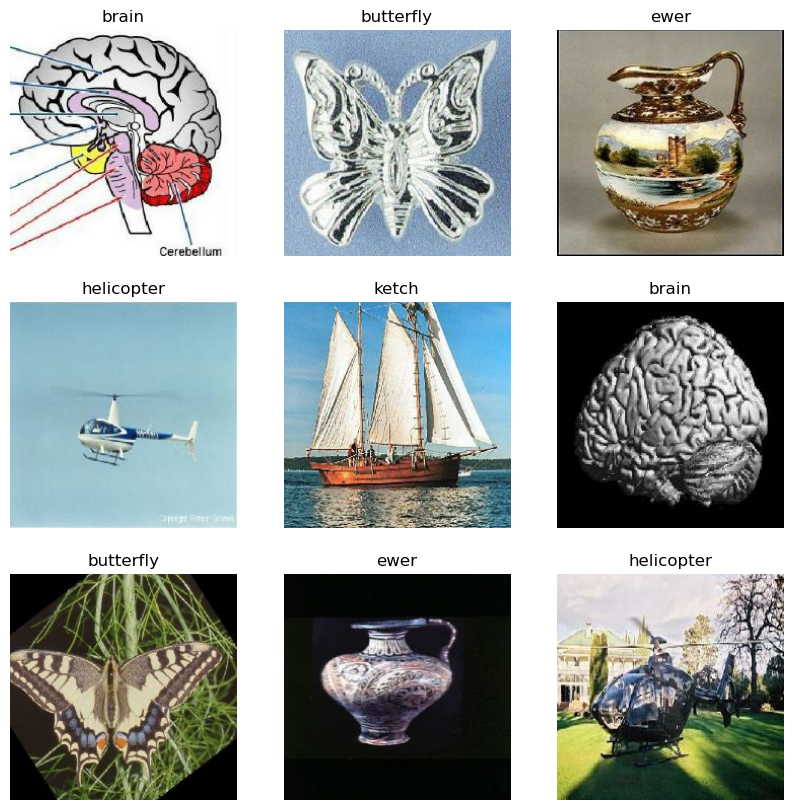

In [34]:
image_super = [] # pairs of images and corresponding labels (will be used for plotting and other experiments)
plt.figure(figsize=(10, 10))
for i in range(9):
    label_idx = i%5
    for batch_images, batch_labels in train_ds:
        mask = (batch_labels == label_idx)
        if tf.reduce_any(mask): #checks if any value in mask tensor is true
            indices = tf.argmax(mask)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow((batch_images[indices].numpy()*255).astype("uint8"))
            plt.title(class_names[batch_labels[indices]])
            plt.axis("off")
            image_super.append([batch_images[indices], batch_labels[indices]])
            break  

### Fit the Model

In [35]:
%%script echo skip
history_vgg19 = vgg19_transfer.fit(train_ds,
                                epochs=50,
                                batch_size=32,
                                validation_data=valid_ds,
                                callbacks=[save_layer_weights, early_stopping]
                                )

skip


In [36]:
%%script echo skip
best_w = pd.read_csv('sequential-model-weights/output_layer_epoch_2_weights.csv', dtype='float32').values
best_b = pd.read_csv('sequential-model-weights/output_layer_epoch_2_bias.csv', dtype='float32').values[0]

skip


### Transfer learning summary 
- best model weights is achieved in epoch 3





In [37]:
model.predict(test_ds).argmax(axis=1)

4/4 [==============================] - 18s 541ms/step


array([2, 2, 1, 4, 4, 4, 0, 1, 4, 1, 4, 4, 1, 2, 1, 4, 2, 1, 4, 2, 1, 0,
       2, 4, 4, 2, 0, 0, 3, 1, 3, 0, 2, 1, 0, 1, 1, 1, 4, 4, 3, 2, 3, 4,
       0, 0, 3, 2, 1, 4, 3, 0, 0, 2, 2, 3, 1, 3, 0, 1, 0, 3, 2, 0, 1, 3,
       3, 3, 0, 1, 2, 0, 4, 1, 0, 3, 4, 2, 1, 3, 1, 1, 1, 3, 3, 3, 2, 4,
       0, 1, 4, 1, 0, 0, 3, 2, 2, 4, 4, 3])

In [38]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print("test accuracy = ", test_acc)
print("test loss ", test_loss)

test accuracy =  0.9599999785423279
test loss  0.11188392341136932


In [39]:
_, train_acc = model.evaluate(train_ds, verbose=0)
_, val_acc = model.evaluate(valid_ds, verbose=0)
print(f"training accuracy = {train_acc :.3f}")
print(f"validation accuracy = {val_acc :.3f}" )

training accuracy = 1.000
validation accuracy = 0.980


### Loading saved model 
- checking if our model has been saved correctly or not

In [40]:
%%script echo skip
best_op_wb = vgg19_transfer.get_layer('output_layer').get_weights()
sum(pd.read_csv('sequential-model-weights/output_layer_epoch_2_weights.csv', dtype='float32').values == best_op_wb[0])

skip


- We can see that the our saved weights are exactly matching with the current best weights here epoch = 3(epoch idx=2)

In [166]:
for hl in model.layers:
    hl.trainable = False

### Confusion Matrix plot

In [41]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=10): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # overall accuracy
  true_cls = 0
  for i in range(cm.shape[0]):
    true_cls += cm[i][i]
  acc_all = (true_cls/len(y_true))*100

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  # fig.colorbar(cax) # for now skip plotting heat index

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes 
  ax.set(title=f"Confusion Matrix\naccuracy: {acc_all}",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

In [42]:
def plot_confusion_matrix(data_set, label_names):
  # Get true labels
  true_labels = []
  predicted_ =[]
  for images, labels in data_set:
    true_labels += labels.numpy().tolist()
    predicted_ += model.predict(images, verbose=0).argmax(axis=1).tolist()
  make_confusion_matrix(true_labels, predicted_, label_names)


plotting confusion matrix with classes

                    |------------------- confusion matrix for training datasets --------------|



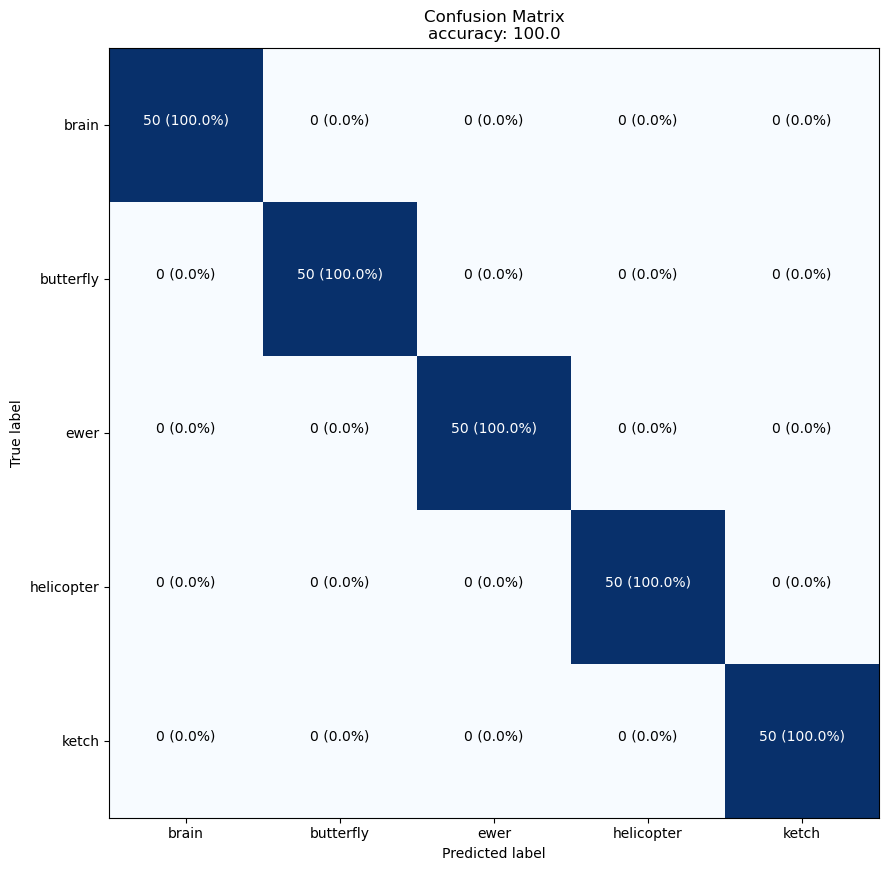

In [43]:
print('                    |------------------- confusion matrix for training datasets --------------|')
print()
plot_confusion_matrix(train_ds, class_names)

                    |------------------- confusion matrix for validation datasets --------------|



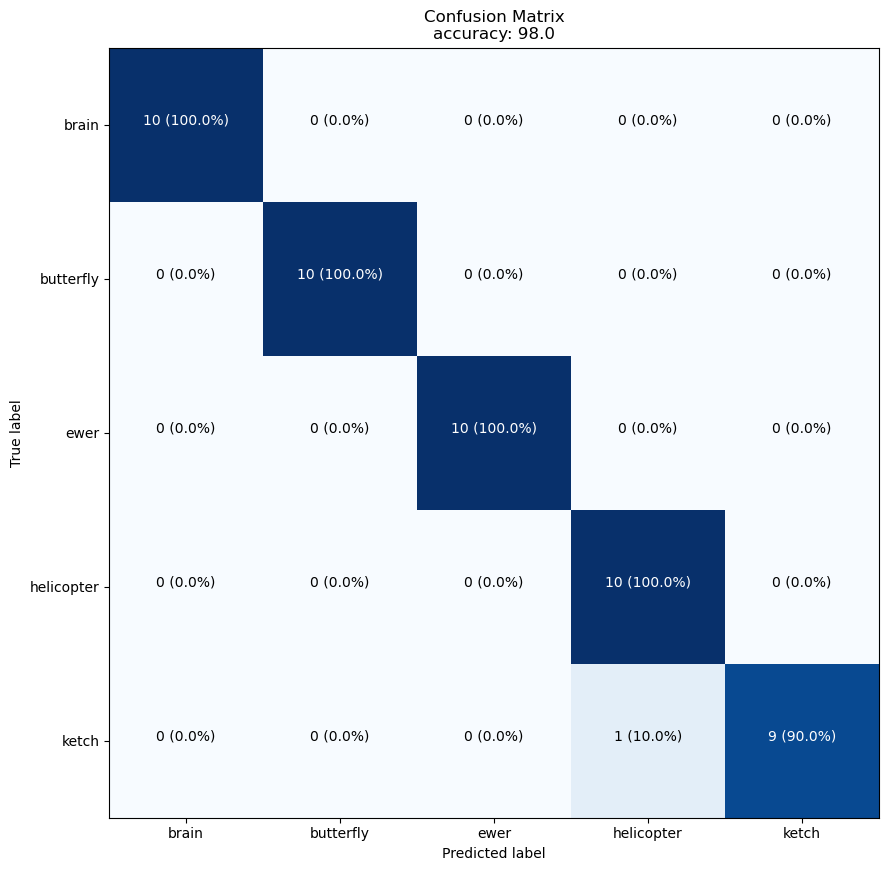

In [44]:
print('                    |------------------- confusion matrix for validation datasets --------------|')
print()
plot_confusion_matrix(valid_ds, class_names)

                    |------------------- confusion matrix for test datasets --------------|



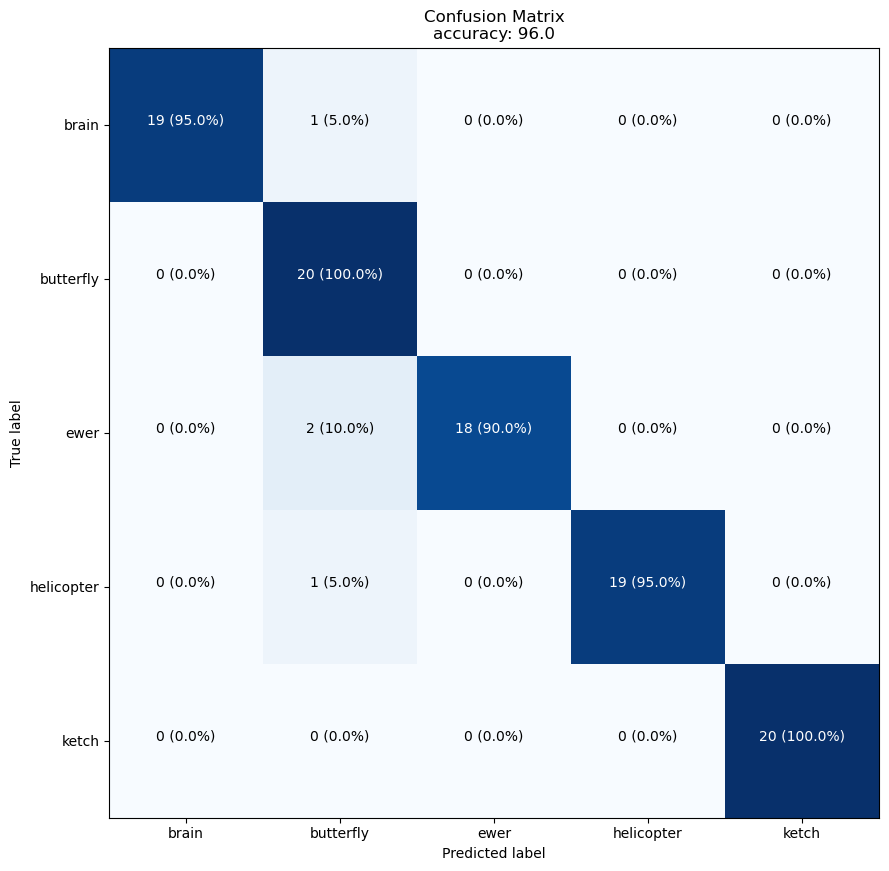

In [45]:
print('                    |------------------- confusion matrix for test datasets --------------|')
print()
plot_confusion_matrix(test_ds, class_names)

### Grad-CAM class activation visualization
--- 
### [stackoverflow refrence link](https://stackoverflow.com/questions/60623869/gradcam-with-guided-backprop-for-transfer-learning-in-tensorflow-2-0)
---

In [46]:
last_conv_layer_name = "block5_conv4"

In [55]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [140]:
def save_and_display_gradcam(img, heatmap, cam_path = 'cam.jpg', alpha=0.4):
    # Load the original image
#     img = keras.preprocessing.image.load_img(img_path)
#     img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

#     # Save the superimposed image
#     superimposed_img.save(cam_path)

#     # Display Grad CAM
#     display(Image(cam_path))
    img = keras.preprocessing.image.img_to_array(superimposed_img)/255.0
    return img




In [93]:
def compute_all_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    if model.layers[-1].activation != None:
        model.layers[-1].activation = None
    
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape(persistent=True) as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        num_class = preds.shape[1]
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channels = [preds[:, i] for i in range(num_class)]
    
    
    grads_all = [tape.gradient(class_channels[i], last_conv_layer_output) for i in range(num_class)]

    pooled_grads_all = [tf.reduce_mean(grads_all[i], axis=(0, 1, 2)) for i in range(num_class)]
    
    heatmap_all = []
    last_conv_layer_output = last_conv_layer_output[0]
    for i in range(num_class):
        heatmap = last_conv_layer_output @ pooled_grads_all[i][..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        heatmap_all.append(heatmap)
    
    # return heatmap of all classes along with class_index of predicted class as a dict
    grad_cams = {'heatmaps': heatmap_all, 'pred_idx': pred_index}
    return grad_cams

In [59]:
array = image_super[2][0].numpy()
img_array = np.expand_dims(array, axis=0)
preds = model.predict(img_array, verbose=0 )
print("Predicted:", class_names[preds.argmax(axis=1)[0]])

Predicted: ewer


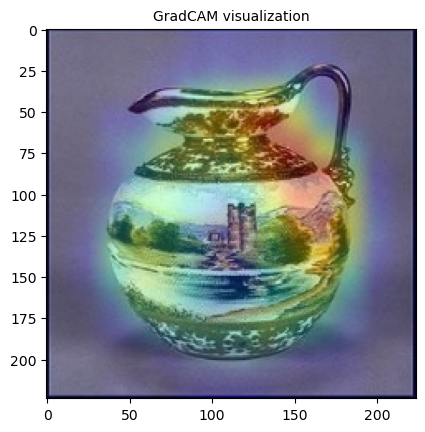

In [165]:
array = image_super[2][0].numpy()
img_array = np.expand_dims(array, axis=0)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
img = save_and_display_gradcam(array*255, heatmap)
plt.imshow(img)
plt.title('GradCAM visualization', fontsize=10)
plt.show()

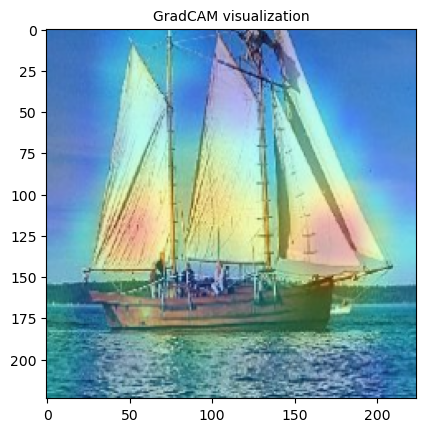

In [167]:
array = image_super[4][0].numpy()
img_array = np.expand_dims(array, axis=0)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
img = save_and_display_gradcam(array*255, heatmap)
plt.imshow(img)
plt.title('GradCAM visualization', fontsize=10)
plt.show()

In [161]:
def visualise_heat_map_all(img_, model=model, last_conv_layer_name = "block5_conv4"):
    array = img_.numpy()
    img_array = np.expand_dims(array, axis=0)
    cal_gradcams = compute_all_gradcam_heatmap(img_array, model, last_conv_layer_name)
    plt.figure(figsize=(10, 10))
    for i, heatmap in enumerate(cal_gradcams.get('heatmaps')):
        ax = plt.subplot(3, 3, i + 1)
        img = save_and_display_gradcam(array*255, heatmap)
        plt.imshow(img)
        title = ""
        if i == cal_gradcams.get('pred_idx'):
            title = f'with respect to actual\npredicted class: {class_names[i]}'
        else:
            title = f'with respect to\nclass: {class_names[i]}'
        plt.title(title, fontsize=10)
        plt.axis("off")


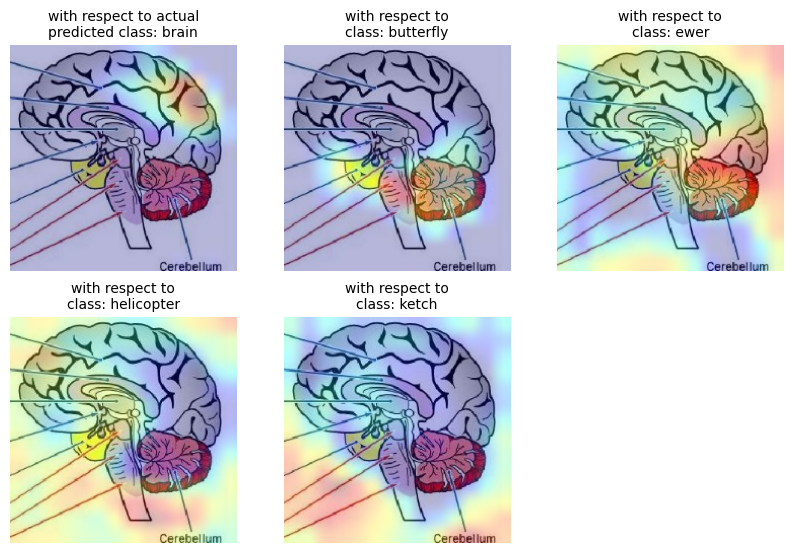

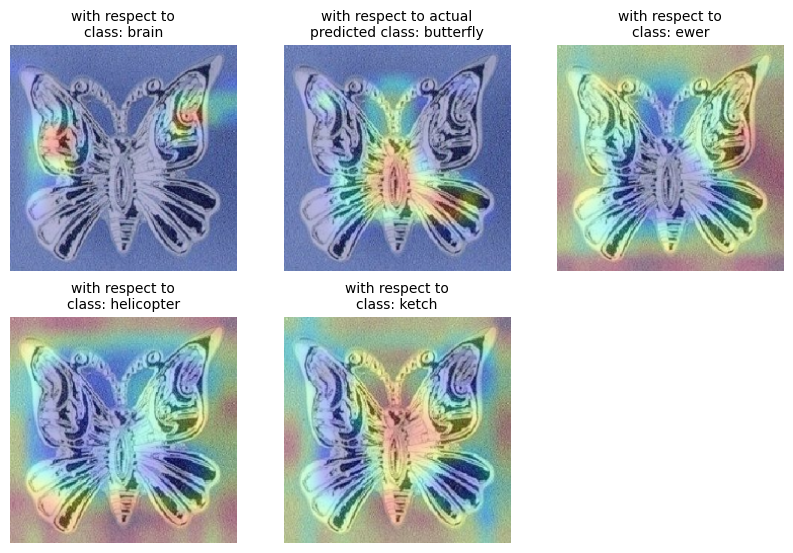

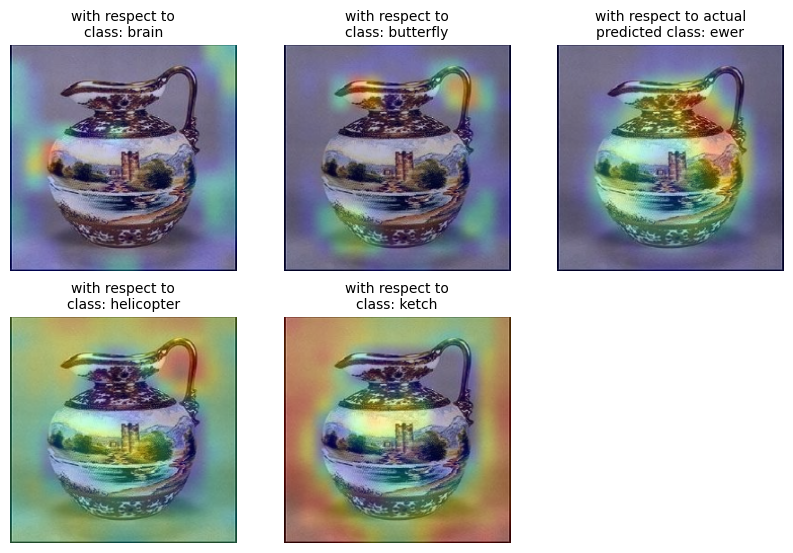

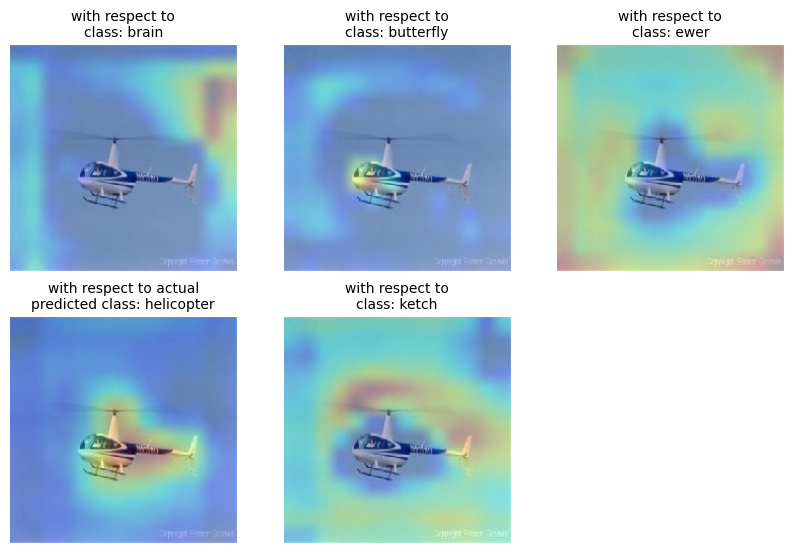

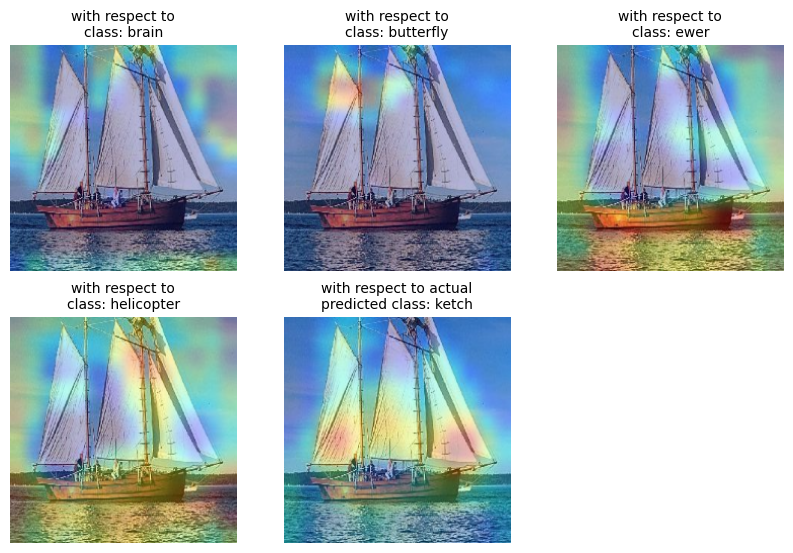

In [162]:
for i in range(5):
    visualise_heat_map_all(image_super[i][0], model)